# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [231]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo environnement

In [232]:
%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

### Define Materials

env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


In [233]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.2)
water.add_s_alpha_beta('c_H_in_H2O')
water_bis = openmc.Material(name="water_bis")
water_bis.add_nuclide('H1', 2.0)
water_bis.add_nuclide('O16', 1.0)
water_bis.set_density('g/cm3', 1.)
water_bis.add_s_alpha_beta('c_H_in_H2O')


    
model.materials = openmc.Materials([uo2, zirconium, water,water_bis]) 
model.materials.export_to_xml()

### Create region

In [234]:
fuel_outer_radius = openmc.ZCylinder(r=0.39)
clad_inner_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')
    
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -gap_outer_radius
clad_region = +clad_inner_radius & -clad_outer_radius
water_region = +left & -right & +bottom & -top & +clad_outer_radius
   

### Create pincell_side

In [235]:
 
fuel_side = openmc.Cell(name='fuel_side')
fuel_side.fill = uo2
fuel_side.region = fuel_region
gap_side = openmc.Cell(name='gap_side')
gap_side.region = gap_region
clad_side = openmc.Cell(name='clad_side')
clad_side.fill = zirconium
clad_side.region = clad_region
moderator_side = openmc.Cell(name='moderator_side')
moderator_side.fill = water
moderator_side.region = water_region

u_side = openmc.Universe(cells=(fuel_side, gap_side, clad_side, moderator_side))

### Create pincell_diag

In [236]:
fuel_diag = openmc.Cell(name='fuel_diag')
fuel_diag.fill = uo2
fuel_diag.region = fuel_region
gap_diag = openmc.Cell(name='gap_diag')
gap_diag.region = gap_region
clad_diag = openmc.Cell(name='clad_diag')
clad_diag.fill = zirconium
clad_diag.region = clad_region
moderator_diag = openmc.Cell(name='moderator_diag')
moderator_diag.fill = water_bis
moderator_diag.region = water_region
    
u_diag = openmc.Universe(cells=(fuel_diag, gap_diag, clad_diag, moderator_diag))

### Create guide tube pincell

In [237]:
water_guide_region= -clad_inner_radius

water_guide = openmc.Cell(name='water_guide')
water_guide.fill = water
water_guide.region = water_guide_region
clad_guide = openmc.Cell(name='clad_guide')
clad_guide.fill = zirconium
clad_guide.region = clad_region
moderator_guide = openmc.Cell(name='moderator_guide')
moderator_guide.fill = water
moderator_guide.region = water_region
    
u_guide = openmc.Universe(cells=(water_guide, clad_guide, moderator_guide))



### Define assembly

In [238]:
assembly = openmc.RectLattice()
assembly.lower_left = (-1.5*pitch, -1.5*pitch)
assembly.pitch = (1.26, 1.26)
assembly.universes = [[u_diag, u_side, u_diag],
                      [u_side, u_guide, u_side],
                      [u_diag, u_side, u_diag]]
            
    
    
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

min_x = openmc.XPlane(x0=0., boundary_type='reflective')
max_x = openmc.XPlane(x0=+1.5*pitch, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0., boundary_type='reflective')
max_y = openmc.YPlane(y0=+1.5*pitch, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z
    
    
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)
model.geometry = openmc.Geometry(root_universe)
model.geometry.export_to_xml()

# model.geometry.get_all_material_cells().values()
# model.geometry.get_all_materials().values()


/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=0.
  warn(msg, IDWarning)


### Plot assembly

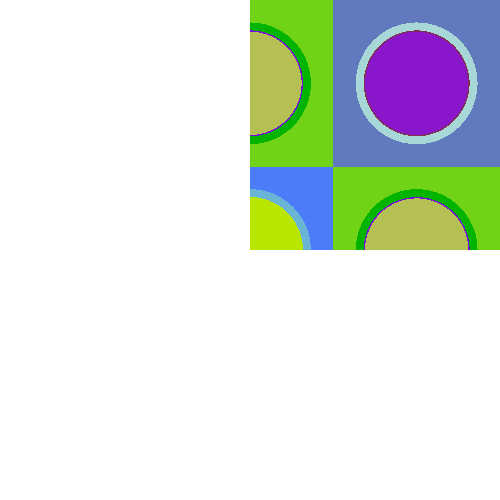

In [239]:
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (3*pitch, 3*pitch)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [240]:
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0.1,0.1,0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([10.0e6], [1.0])
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 50000
settings.output = {'tallies':True}
model.settings = settings
model.settings.export_to_xml()

### Define and choose energy group

In [241]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create MGXS tallies for mgxs directory

In [242]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
#tally_flux.merge_tallies()
model.tallies = tallies
#print(model.tallies)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


### Run OpenMC model

In [243]:
model.export_to_xml()
sp_file = model.run()
sp = openmc.StatePoint(sp_file)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3017.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2702.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2710.
  warn(msg, IDWarning)


[Machine2:15269] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%

### Plot Flux

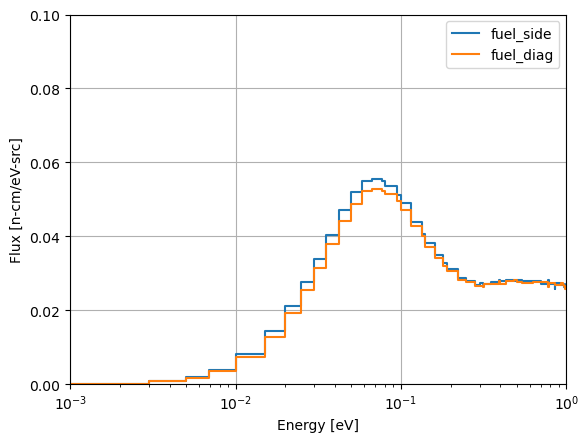

In [244]:
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import LogLocator

#Enter the name of the cell type string// example: fuel_out = openmc.Cell(name='fuel_out') ///
cell_plot=['fuel_side','fuel_diag']#,'moderator_in']


sp = openmc.StatePoint(sp_file)
sp.tallies
tally_flux_id=[]
for index, tally in enumerate(sp.tallies):
    if sp.tallies[tally].scores==['flux']:
        t=sp.tallies[tally]

def flux_cell(cell):
    
    cell_index = 99
    cell_id=99
    # print(model.geometry.get_all_material_cells().values())
    i=0
    for all_cell in model.geometry.get_all_material_cells().values():
        i=i+1
        if all_cell.name==cell:
            cell_index=all_cell.id
            cell_id=i-1
            # print(cell_id)
           
    tally_data_reshaped =t.get_reshaped_data()
    flux=tally_data_reshaped[cell_id]
    
    liste_reduced = []
    for under_liste in flux:
        nombre = under_liste[0][0]
        liste_reduced.append(nombre)
    flux=liste_reduced
    return(flux)
    

dE=np.diff(choose_group)
Emid=choose_group[:-1]+dE/2

fig, ax = plt.subplots()
for i,cell in enumerate(cell_plot):
    flux=flux_cell(cell_plot[i])    
    mg_spectrum=flux / np.sum(flux)
    ax.step(choose_group[:-1], Emid*mg_spectrum/dE, where='post', label=cell_plot[i])
ax.set_xscale('log')
ax.xaxis.set_major_locator(FixedLocator(locs=np.logspace(-5, 7, 13)))
locmin=LogLocator(base=10,subs=np.linspace(0,1.0,11)[1:-1],numticks=1000)
ax.xaxis.set_minor_locator(locmin)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.set_xlim(1e-3,1.)
ax.set_ylim(0,0.1)
ax.grid()
ax.legend()
plt.show()


### Print MGXS

In [245]:
mgxs_lib.load_from_statepoint(sp)
type(mgxs_lib)
reaction_print = 'total'
#Enter the name of the cell type openmc.Cell /// example: fuel_out = openmc.Cell(name='fuel_out') ///
cell_print=fuel_side
df_mgxs = mgxs_lib.get_mgxs(cell_print, reaction_print)
df_mgxs.print_xs()

Multi-Group XS
	Reaction Type  =	total
	Domain Type    =	cell
	Domain ID      =	199
	Cross Sections [cm^-1]:
            Group 1 [17332500.0 - 19640300.0eV]:	2.09e-01 +/- 9.36e+01%
            Group 2 [14918200.0 - 17332500.0eV]:	2.06e-01 +/- 2.67e+01%
            Group 3 [13840300.0 - 14918200.0eV]:	2.05e-01 +/- 2.58e+01%
            Group 4 [11618300.0 - 13840300.0eV]:	2.00e-01 +/- 8.84e+00%
            Group 5 [10000000.0 - 11618300.0eV]:	1.92e-01 +/- 4.33e+00%
            Group 6 [8187310.0  - 10000000.0eV]:	1.91e-01 +/- 2.44e+00%
            Group 7 [6703200.0  - 8187310.0 eV]:	1.97e-01 +/- 1.46e+00%
            Group 8 [6065310.0  - 6703200.0 eV]:	1.97e-01 +/- 1.56e+00%
            Group 9 [5488120.0  - 6065310.0 eV]:	2.23e-01 +/- 1.24e+00%
            Group 10 [4493290.0  - 5488120.0 eV]:	2.29e-01 +/- 6.38e-01%
            Group 11 [3678790.0  - 4493290.0 eV]:	2.73e-01 +/- 6.19e-01%
            Group 12 [3011940.0  - 3678790.0 eV]:	2.90e-01 +/- 4.72e-01%
            Group 13 [24

### Plot MGXS from mgxs directory

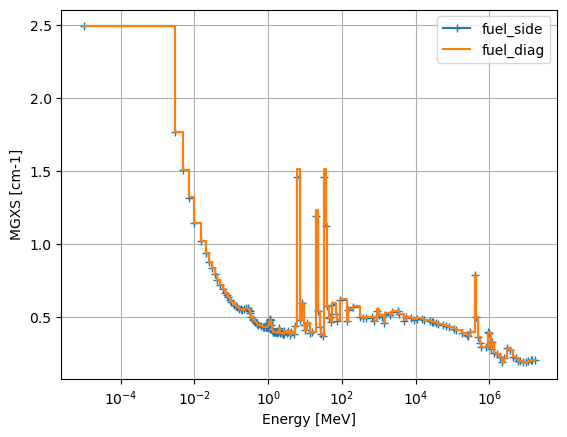

In [246]:
#Enter the name of the cell type openmc.Cell /// example: fuel_out = openmc.Cell(name='fuel_out') ///

reaction_plot = 'total'
cell_plot_1 = fuel_side
cell_name_1='fuel_side'
cell_plot_2 = fuel_diag
cell_name_2='fuel_diag'


mgxs_plot_1 = mgxs_lib.get_mgxs(cell_plot_1, reaction_plot)

mgxs1=mgxs_plot_1.get_pandas_dataframe(xs_type='macro')['mean'].values
mgxs_plot_2 = mgxs_lib.get_mgxs(cell_plot_2, reaction_plot)
mgxs2=mgxs_plot_2.get_pandas_dataframe(xs_type='macro')['mean'].values


fig, ax = plt.subplots()
ax.step(choose_group[:-1], np.flip(mgxs1), where='post', label=cell_name_1,marker='+') 
ax.step(choose_group[:-1], np.flip(mgxs2), where='post', label=cell_name_2) 

        
ax.set_xscale('log')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('MGXS [cm-1]')
ax.grid() 
# bbox = ax.get_position()
# ax.text(bbox.x1 - 0.05, bbox.y0 - 0.05, reaction_plot, fontsize=15, color='red', ha='right')
ax.legend()
plt.show()

In [264]:
openmc_cells = model.geometry.get_all_material_cells().values()
print(openmc_cells)
sp.tallies
#print(openmc_cells)
t=sp.tallies[3687]
sp.tallies[3687].filters
print(sp.tallies[3687].scores)

tally_data_reshaped =t.get_reshaped_data()
print(tally_data_reshaped.shape)

dict_values([Cell
	ID             =	203
	Name           =	fuel_diag
	Fill           =	Material 63
	Region         =	-245
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	205
	Name           =	clad_diag
	Fill           =	Material 64
	Region         =	(246 -247)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	206
	Name           =	moderator_diag
	Fill           =	Material 66
	Region         =	(248 -249 250 -251 247)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	199
	Name           =	fuel_side
	Fill           =	Material 63
	Region         =	-245
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	201
	Name           =	clad_side
	Fill           =	Material 64
	Region         =	(246 -247)
	Rotation       =	None
	Temperature

(9, 172, 1, 6)
173
0 203
3 199


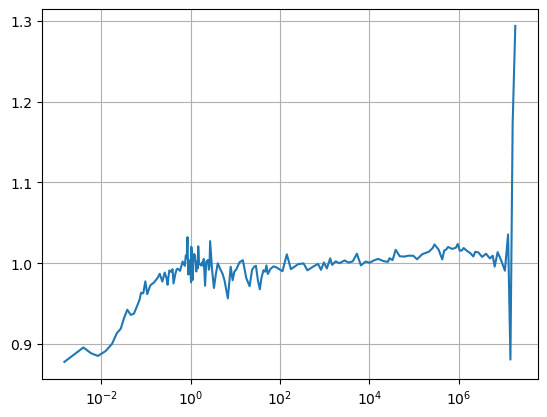

In [266]:
#print(openmc_cells)
t=sp.tallies[3687]
tally_data_reshaped =t.get_reshaped_data()
print(tally_data_reshaped.shape)

flux_190=tally_data_reshaped[3]
flux_192=tally_data_reshaped[4]

# print(flux_190)
energy_filter_id = 0
flux_score_id = 0
flux = tally_data_reshaped[:,:,energy_filter_id,flux_score_id]
E = choose_group
print(len(E))
dE = np.diff(E)
Emid = E[:-1] + dE/2
plt.figure()



for i,cell in enumerate(openmc_cells):
    if cell.name=='fuel_diag' :
        # normalize so that integral over E sums to 1.
        mg_spectrum_diag = flux[i,:] / np.sum(flux[i,:])*Emid/dE
        print(i,cell.id)
    if cell.name=='fuel_side' :
        print(i,cell.id)
        # normalize so that integral over E sums to 1.
        mg_spectrum_side = flux[i,:] / np.sum(flux[i,:])*Emid/dE
plt.semilogx(Emid, mg_spectrum_diag/mg_spectrum_side)#, label=cell.name)
#plt.legend()
plt.grid()
plt.show()